# Question 2

1) Message passing via direct inferenece

2) Mean field approximation

3) Gibbs sampling

- work out how you get the joint of the two corners as this is still an issue, then use the methods above ot find.

In [730]:
import numpy as np
import matplotlib.pyplot as plt

In [132]:
def potential(xi, xj, beta):
    return np.exp((beta*(xi == xj)))

# Message passing via direct inference

Here message passing is done by simplifing it to a single connected graph and message passing that way and then decomposing at the end to the get corners based of the message going into x10

- will need to initialise each variable with the associated potentials
- will then need to send messages back and forth - forward/backward from before?
- then given the output for X10 we will have to decompose by summing over all possible values of other nodes


In [523]:
def perms(n):
    # Define a function to get all permutations of length n of binary bits
    if not n:
        return

    for i in range(2**n):
        s = bin(i)[2:]
        s = "0" * (n-len(s)) + s
        s = list(s)
        s = [int(i) for i in s]
        yield s

In [524]:
fives = np.array(list(perms(5)))
#print(fives)

In [525]:
def forward_pass(T,initial,n):
    alpha = np.zeros((n, T.shape[0]))
    alpha[0,:] = initial 
    
    for t in range(1,n):
        for j in range(T.shape[0]):
            alpha[t,j]=alpha[t-1]@T[j,:]
            
    return alpha
            

In [526]:
def backward_pass(T,n):
    beta = np.zeros((n, T.shape[0]))
    beta[n - 1,:] = np.ones((1,T.shape[0]))
    
    for t in range(n-2,-1,-1):
        for j in range(T.shape[0]):
            beta[t,j]=beta[t+1]@T[:,j]
        
    return beta
    

In [527]:
def extract_prob(n,a,b,prob):
    # n is the size of the matrix we are looking at
    # prob - marginal for the column what all combinations are
    # a the first first varialbe to take joint of 
    # bthe second variable to take join of
    # Will return P a prob matrix representing the joint probability over (n,m) in the column
    
    # Obtain all permutations
    perm = np.array(list(perms(n)))
    
    # Intialise P - rows are the first corner and columns are second corner
    P = np.zeros((2,2))
    
    # Cycle through all permuations and sum up for the probs in that row
    for row in range(perm.shape[0]):
        P[perm[row,a],perm[row,b]] += prob[row]
        #P[perm[row,a],perm[row+1,a]] += prob
        
            
    return P

In [528]:
def exact_inference(n, beta):
    # n - represents the size of our grid (here we will be using 10)
    
    
    # Firstly lets get all permutatoins of a 10 element 2 bit marker so we can perform potentials between them.
    perm = np.array(list(perms(n)))
    
    # Initial probabilities 
    initial = np.ones((1,2**n))
    
    for row in range(perm.shape[0]):
        for col in range(perm.shape[1]-1):
            initial[0,row] *= potential(perm[row,col],perm[row,col+1],beta)
            
    initial = initial/np.sum(initial)
            
    # Lets now work out the possible transitions between configurations of one column and another, this is a 2^10 by 2^10
    T = np.ones((2**n, 2**n))
    
    for i in range(2**n):
        for j in range(2**n):
            for k in range(n):
                T[i,j] *= potential(perm[i,k], perm[j,k], beta)
                
    T = T/np.sum(T, axis=0)
                
    
    forw = forward_pass(T,initial,n)
    back = backward_pass(T,n)
    
    posterior = forw[n-1,:]*back[n-1,:]
    
    P = extract_prob(n,0,9,posterior)
    
    return P

In [207]:
size = 10
beta = 1
exact_inference(size, beta)

array([[0.25, 0.25],
       [0.25, 0.25]])

In [208]:
size = 10
beta = 4 
exact_inference(size, beta)

array([[0.34297269, 0.15702731],
       [0.15702731, 0.34297269]])

In [209]:
size = 10
beta = 0.01 
exact_inference(size, beta)

array([[0.25, 0.25],
       [0.25, 0.25]])

In [529]:
size = 10
beta = 10
exact_inference(size, beta)

array([[0.49938785, 0.00061215],
       [0.00061215, 0.49938785]])

# Mean field approximation

- coordinate ascent will be used for updates

In [651]:
def potential(xi, xj, beta):
    return np.exp((beta*(xi == xj)))

In [791]:
def free_energy(q,beta):
    pos, row, col = q.shape
    
    FE = 0 
    for i in range(row):
        for j in range(col):
            for k in range(pos):
                # Add the entropy
                FE += entropy(q[k,i,j])
                
                # Now we need E-k[log p(xk|X-k)] over qk
                FE += q[k,i,j]*expectation(i,j,k,q,beta)                         
    return FE

In [787]:
def entropy(q):
    # Binary entropy function
    H = -q*np.log(q) - (1-q)*np.log(1-q)
    return H

In [788]:
def get_post(q):
    # This function is used to extract the posterior on the two corners
    
    #post = np.concatenate((q[:,0,9].reshape(1,2),q[:,9,9].reshape(1,2)), axis = 0)
   # post = post/np.sum(post)
    post = q[:,0,9].reshape(2,1)@q[:,9,9].reshape(1,2)
    return post

In [780]:
def expectation(i,j,xk,q,beta):
    # Function to conpute the expectation with of E-k[log P(xk|X-K)]
    # i,j are the coordinates of the current node
    # xk is value of xk node 
    # q is our distribution
    
    # This expectation only depends on the neighbouring nodes
    height, width = q.shape[1:]
    
    ex = 0
    
    if i>0:
        for k in range(2):
            potent = potential(k,xk,beta)
            ex += q[k,i-1,j]*np.log(potent/2)
                
    if i<height-1:
        for k in range(2):
            potent = potential(k,xk,beta)
            ex += q[k,i+1,j]*np.log(potent/2)
    if j > 0:
        for k in range(2):
            potent = potential(k,xk,beta)
            ex += q[k,i,j-1]*np.log(potent/2)
            
    if j < width - 1:
        for k in range(2):
            potent = potential(k,xk,beta)
            ex += q[k,i,j+1]*np.log(potent/2)  
                
    return ex   

In [789]:
def mean_field_approx(shape, beta,max_iter):
    # Here we define the mean field approximation function which randomly initialises the distribtuions q and iteratively updates the indvidual ones
    # by summing over the others
    rows,cols = shape
    epsilon = 0.000001
    
    # need a posterior on q for each element in the grid - 2 for 0 or 1 and then of size grid.
    q = np.zeros((2,rows,cols))
    
    #randomly initialise
    for i in range(rows):
        for j in range(cols):
            q[0,i,j] = np.random.rand()
            q[1,i,j] = 1- q[0,i,j]
    
    free_eng = []
    free_eng.append(free_energy(q,beta))
    
    print('Free energy: ', free_energy(q,beta))
    
    #print(q)
    
    # We need to iteratively update q at each step of the way
    converged = False
    iterations = 0
    
    while converged == False:
        # First we wish to update the q values based off those around
        
        new_q = np.zeros((2,rows,cols))
        for i in range(rows):
            for j in range(cols):
                for k in range(0,2):
                    #print(expectation(i,j,k,q,beta))
                    new_q[k,i,j] = np.exp(expectation(i,j,k,q,beta))
                summond = np.sum(new_q[:,i,j])
                if summond == 0:
                    summond = 1
                new_q[:,i,j] = new_q[:,i,j]/summond
                    
        print(new_q)
        # Now we want to compute the ELBO free energy
        free_eng.append(free_energy(new_q,beta))
        #print(iterations)
        #print('Free energy: ',free_energy(new_q, beta))       
        
        iterations += 1
        if iterations == max_iter or np.linalg.norm(q - new_q)<=epsilon:
            converged = True
        q = new_q
    
    x = np.arange(iterations+1)
    plt.plot(x,free_eng)                    
                        
    #print(q)
    print('Free energy: ',free_energy(q, beta))    
    post = get_post(q)
    #print(np.sum(post))
    return post

In [775]:
check = np.zeros((2,2))
beta = 0.01

for i in range(2):
    for j in range(2):
        check[i,j] = potential(i,j,beta)
print(check)
    

[[1.01005017 1.        ]
 [1.         1.01005017]]


Free energy:  -151.35775256822566
Free energy:  -109.103548889591


array([[0.25, 0.25],
       [0.25, 0.25]])

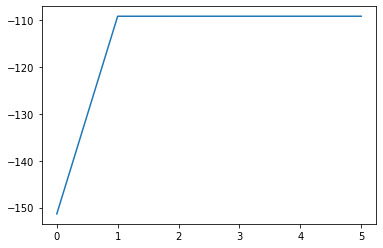

In [782]:
shape = 10,10
beta = 0.01
max_iter=20
mean_field_approx(shape, beta,max_iter)

Free energy:  27.48047455771349
[[[0.3076588  0.67535099 0.46605789 0.60682251 0.5110133  0.25844804
   0.64246305 0.37006481 0.23770723 0.45774701]
  [0.5615332  0.26308787 0.61867729 0.57628075 0.22838279 0.62331329
   0.12256388 0.22514565 0.52565775 0.06316009]
  [0.12910494 0.7096682  0.34321102 0.21002922 0.54949652 0.16919136
   0.32047618 0.24986381 0.10259668 0.5655744 ]
  [0.62679788 0.10615196 0.36581582 0.12433447 0.36367133 0.34375188
   0.37697221 0.16103595 0.30859185 0.42125261]
  [0.44840727 0.29121892 0.09049164 0.48877993 0.13956911 0.6565276
   0.12145697 0.38840118 0.33584074 0.60776924]
  [0.51422144 0.53869433 0.19550119 0.28353223 0.60388855 0.50581267
   0.82138229 0.12629337 0.66863579 0.31661345]
  [0.57749893 0.45121093 0.50851935 0.55053372 0.86530316 0.36933974
   0.73940418 0.74990564 0.3380652  0.60413611]
  [0.80581566 0.33696461 0.48969231 0.71899232 0.1989809  0.74898595
   0.18977192 0.70305162 0.2396829  0.45026638]
  [0.46379933 0.63916176 0.465034

array([[0.02389451, 0.13068399],
       [0.13068399, 0.7147375 ]])

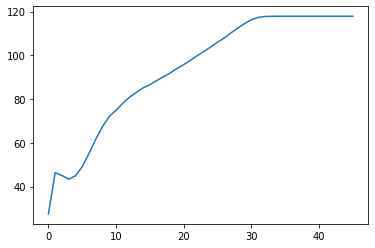

In [792]:
shape = 10,10
beta = 1
max_iter=100
mean_field_approx(shape, beta,max_iter)

# Gibbs sampling

In [404]:
def neighbours(i,j,arr):
    #This function can be used to get all the labels for neightbouring points.
    
    height, width = arr.shape
    #if i > 0:
    #    yield arr[i - 1, j]
    if i < height - 1:
        yield arr[i + 1, j]
    #if j > 0:
    #    yield arr[i, j - 1]
    if j < width - 1:
        yield arr[i, j + 1]

In [295]:
def potential(xi, xj, beta):
    return (beta*(xi == xj))

In [296]:
def get_potentials(beta, num_lables):
    potential_matrix = np.zeros((num_lables, num_lables))
    
    for i in range(2):
        for j in range(2):
            potential_matrix[i,j] = potential(i, j, beta)
    
    return potential_matrix  

In [402]:
class MarkovRandomField():
    # This class will define our markov random field 
    # Shape is the size we want which here will be 10x10
    # potentials - these will be the pairwise potentials which are found depending on [0,0] [1,0] [0,1], [1,1]
    
    def  __init__(self, shape, beta, num_labels=2):
        self.beta = beta
        self.label = np.random.randint(0, num_labels, shape)
        self.potentials = get_potentials(self.beta, num_labels)
    
    # Define probabitility function to get whole probability.
    def probability(self):
        P = 0
        for (i, j), label in np.ndenumerate(self.label):
            for adjacent_label in neighbours(i, j, self.label):
                P += self.potentials[label, adjacent_label]
        return np.exp(P)
    
    def __len__(self):
        return self.label.size
    
    def visualise(self):
        print(self.label)

In [431]:
def Gibbs_sampling(shape,runs,beta):
    
    Prob = np.zeros((2,2))
    
    for run in range(runs):
        # For each run we wish to randomly initialise our random field and then update it to convergence
        # Then see what the values of the two corners are and update accordingly.
        field = MarkovRandomField(shape, beta)
        
        node_order = [np.unravel_index(i, shape) for i in range(len(field))]

        for iteration in range(50):
            np.random.shuffle(node_order)
            
            for n, (i, j) in enumerate(node_order):
                field.label[i, j] = 0
                prLabelEquals0 = field.probability()

                field.label[i, j] = 1
                prLabelEquals1 = field.probability()

                norm_const = prLabelEquals0 + prLabelEquals1
                prLabelEquals0 = prLabelEquals0/norm_const
                prLabelEquals1 = prLabelEquals1/norm_const

                # sample from a normal and execept if greater then something
                r = np.random.rand()
                if r <= prLabelEquals1:
                    field.label[i, j] = 1
                else:
                    field.label[i, j] = 0
                
        Prob[field.label[0,9],field.label[9,9]] += 1
        
    Prob = Prob/np.sum(Prob)
    
    return Prob

In [354]:
shape = 10,10
runs = 1000
beta = 0.01
Gibbs_sampling(shape,runs,beta)

array([[0.253, 0.228],
       [0.266, 0.253]])

In [355]:
shape = 10,10
runs = 1000
beta = 1
Gibbs_sampling(shape,runs,beta)

array([[0.246, 0.247],
       [0.235, 0.272]])

In [476]:
shape = 10,10
runs = 1000
beta = 4
Gibbs_sampling(shape,runs,beta)

C:\Users\henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


array([[0.387, 0.125],
       [0.116, 0.372]])

In [210]:
shape = 10, 10
#Beta value to shuffle over.
beta = 10
field = MarkovRandomField(shape, beta)

In [188]:
field.visualise()

[[0 1 0 0 1 0 0 1 0 0]
 [1 1 1 0 0 0 1 0 0 1]
 [1 0 0 0 0 1 1 1 1 1]
 [0 0 0 1 0 1 1 1 0 1]
 [1 1 0 1 0 1 1 1 0 0]
 [0 0 1 1 0 1 0 1 1 0]
 [1 0 1 0 1 1 0 0 1 1]
 [0 1 0 1 0 1 1 0 0 0]
 [0 0 0 1 0 1 0 1 0 1]
 [1 1 1 1 0 1 1 1 0 0]]


In [189]:
print(field.probability())
print(field.probability_corners())

5.584528464275955
[[1.02020134 1.01005017]
 [1.01005017 1.        ]]


In [475]:
shape = 10, 10
#Beta value to shuffle over.
beta = 4
field = MarkovRandomField(shape, beta)

node_order = [np.unravel_index(i, shape) for i in range(len(field))]

field.visualise()

for iteration in range(20):
    #field.visualise()
    np.random.shuffle(node_order)
    #this is 
    for n, (i, j) in enumerate(node_order):
        field.label[i, j] = 0
        prLabelEquals0 = field.probability()
        
        field.label[i, j] = 1
        prLabelEquals1 = field.probability()
        
        #print(prLabelEquals0,prLabelEquals1)

        norm_const = prLabelEquals0 + prLabelEquals1
        prLabelEquals0 = prLabelEquals0/norm_const
        prLabelEquals1 = prLabelEquals1/norm_const
        
        # sample from a normal and execept if greater then something
        r = np.random.rand()
        if r <= prLabelEquals1:
            field.label[i, j] = 1
        else:
            field.label[i, j] = 0

print('\n')
field.visualise() 

[[1 1 1 0 0 1 1 0 1 1]
 [0 0 0 1 0 0 0 1 0 1]
 [0 0 0 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0]
 [1 1 1 1 0 1 0 1 1 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 1 1 1]
 [1 1 0 1 1 1 1 0 0 1]
 [0 1 0 1 0 1 0 1 1 0]]


[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]
